In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [2]:
import os

!git clone https://github.com/milesial/Pytorch-UNet.git

# Change to the cloned directory if you want to work inside it
# os.chdir('Pytorch-UNet')

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 618, done.
remote: Total 618 (delta 0), reused 0 (delta 0), pack-reused 618 (from 1)
Receiving objects: 100% (618/618), 47.42 MiB | 42.30 MiB/s, done.
Resolving deltas: 100% (338/338), done.


In [3]:
import os
import glob
import random

# The 'path' variable is available from the previous execution
# It points to the downloaded dataset: /root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1
dataset_base_path = path

# --- Debugging: List contents of the base path to understand the structure ---
print(f"Contents of {dataset_base_path}:")
for item in os.listdir(dataset_base_path):
    print(f"- {item}")
# ----------------------------------------------------------------------

# Define paths for images and masks based on the dataset structure
# Corrected images_dir path based on previous output
images_dir = os.path.join(dataset_base_path, 'ISIC2018_Task1-2_Training_Input')
masks_dir = os.path.join(dataset_base_path, 'ISIC2018_Task1_Training_GroundTruth')

# Get all image file paths (assuming .jpg format for images)
# and extract base filenames to match with masks
all_image_files = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))

# Extract just the filenames without extensions and full paths
image_basenames = [os.path.splitext(os.path.basename(f))[0] for f in all_image_files]

# Create a list of (image_path, mask_path) tuples
data_pairs = []
for basename in image_basenames:
    image_path = os.path.join(images_dir, basename + '.jpg')
    # Assuming masks have '_segmentation.png' suffix
    mask_path = os.path.join(masks_dir, basename + '_segmentation.png')
    if os.path.exists(image_path) and os.path.exists(mask_path):
        data_pairs.append((image_path, mask_path))

print(f"Found {len(data_pairs)} image-mask pairs in total.")

# Shuffle the data pairs for random split
random.seed(42) # for reproducibility
random.shuffle(data_pairs)

# Define the split sizes
train_size = 2075
val_size = 519

# Ensure the total requested size does not exceed available data
if (train_size + val_size) > len(data_pairs):
    print(f"Warning: Requested split size ({train_size + val_size}) exceeds available data ({len(data_pairs)}). Adjusting sizes.")
    # Prioritize training set if there's not enough data
    train_size = min(train_size, len(data_pairs))
    val_size = min(val_size, len(data_pairs) - train_size)


# Perform the split
train_data = data_pairs[:train_size]
val_data = data_pairs[train_size : train_size + val_size]

print(f"Train set size: {len(train_data)} image-mask pairs")
print(f"Validation set size: {len(val_data)} image-mask pairs")

# You can now use `train_data` and `val_data` for your model training.
# Each element in these lists is a tuple (image_path, mask_path).

# Example of accessing the first training image and mask path
# if train_data:
#     print(f"First training image: {train_data[0][0]}")
#     print(f"First training mask: {train_data[0][1]}")


Contents of /kaggle/input/isic2018-challenge-task1-data-segmentation:
- ISIC2018_Task1-2_Training_Input
- ISIC2018_Task1_Training_GroundTruth
- ISIC2018_Task1-2_Test_Input
- ISIC2018_Task1-2_Validation_Input
Found 2594 image-mask pairs in total.
Train set size: 2075 image-mask pairs
Validation set size: 519 image-mask pairs


In [4]:
!pip install torch torchvision efficient_kan

ERROR: Could not find a version that satisfies the requirement efficient_kan (from versions: none)
ERROR: No matching distribution found for efficient_kan


In [5]:
!    pip install git+https://github.com/Blealtan/efficient-kan.git

  Cloning https://github.com/Blealtan/efficient-kan.git to /tmp/pip-req-build-_wxszlfm
  Running command git clone --filter=blob:none --quiet https://github.com/Blealtan/efficient-kan.git /tmp/pip-req-build-_wxszlfm
  Resolved https://github.com/Blealtan/efficient-kan.git to commit 7b6ce1c87f18c8bc90c208f6b494042344216b11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for efficient-kan: filename=efficient_kan-0.1.0-py3-none-any.whl size=5981 sha256=3fadb37365bda971d6bcb716e5ecf58aca9c70ee79e32324453796857b325548
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsvmvc6q/wheels/0f/0d/a0/241da1f0cfc9b312bfa9766bee1caa361c1e9d6c1358d200be
Successfully built efficient-kan


In [6]:
#  Training with standard Unet model and Evaluating Dice Scores

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# import numpy as np
# import os

# # Add the cloned Pytorch-UNet directory to sys.path
# # This ensures the UNet module can be imported correctly.
# import sys
# sys.path.append('Pytorch-UNet')
# from unet import UNet

# # 1. Define a custom PyTorch Dataset class
# class BasicDataset(Dataset):
#     def __init__(self, data_pairs, target_size=(256, 256)):
#         self.data_pairs = data_pairs
#         self.target_size = target_size

#     def __len__(self):
#         return len(self.data_pairs)

#     @staticmethod
#     def preprocess(pil_img, target_size, is_mask):
#         # Resize to a fixed target_size
#         pil_img = pil_img.resize(target_size, resample=Image.NEAREST if is_mask else Image.BICUBIC)

#         img_np = np.array(pil_img)

#         if len(img_np.shape) == 2: # Grayscale image
#             img_np = np.expand_dims(img_np, axis=2)
#         elif img_np.shape[2] == 3: # RGB image
#             if not is_mask: # Convert RGB image to grayscale for 1-channel UNet input
#                 img_np = np.mean(img_np, axis=2, keepdims=True)
#             else: # Masks should generally be single channel
#                 img_np = img_np[:, :, 0:1] # Take one channel if somehow RGB mask
#         elif img_np.shape[2] == 4: # RGBA
#              if not is_mask: # Convert RGB part to grayscale
#                 img_np = np.mean(img_np[:,:,:3], axis=2, keepdims=True)
#              else:
#                 img_np = img_np[:, :, 0:1] # Take one channel for mask

#         # HWC to CHW
#         img_np = img_np.transpose((2, 0, 1))

#         if is_mask: # Masks are typically binary (0 or 1)
#             # Ensure values are strictly 0 or 1
#             return (torch.from_numpy(img_np) > 0).float() # Convert to float for BCEWithLogitsLoss
#         else: # Images are usually floats [0, 1]
#             return torch.from_numpy(img_np).float() / 255.0 # Normalize to [0, 1]


#     def __getitem__(self, idx):
#         img_path, mask_path = self.data_pairs[idx]

#         img = Image.open(img_path)
#         mask = Image.open(mask_path)

#         # Ensure single channel for masks if necessary (ISIC masks are typically 1-channel PNGs)
#         # For images, we will convert to grayscale in preprocess for 1-channel UNet input
#         if img.mode != 'L' and img.mode != 'RGB': # 'L' is for grayscale
#             img = img.convert('RGB') # Convert to RGB first to handle other modes like RGBA

#         if mask.mode != 'L':
#             mask = mask.convert('L') # Convert mask to grayscale

#         img = self.preprocess(img, self.target_size, is_mask=False)
#         mask = self.preprocess(mask, self.target_size, is_mask=True)

#         return img, mask

# print("BasicDataset class defined successfully.")

# # --- Dice Coefficient function ---
# def dice_coeff(pred, target):
#     smooth = 1e-8 # A small epsilon value to prevent division by zero

#     # Apply sigmoid activation to the model's raw output to get probabilities
#     pred = torch.sigmoid(pred)

#     # Convert probabilities to binary predictions (threshold 0.5)
#     pred = (pred > 0.5).float()

#     # Flatten both predictions and target masks
#     pred = pred.contiguous().view(-1)
#     target = target.contiguous().view(-1)

#     # Calculate intersection and union
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()

#     # Compute Dice coefficient
#     dice = (2. * intersection + smooth) / (union + smooth)
#     return dice

# print("Dice coefficient function defined successfully.")


# # 2. Create Dataset instances
# # Assuming 'train_data' and 'val_data' are available from previous steps
# # Define a fixed target size for all images and masks
# target_image_size = (256, 256) # Example fixed size

# train_dataset = BasicDataset(train_data, target_size=target_image_size)
# val_dataset = BasicDataset(val_data, target_size=target_image_size)

# print(f"Train dataset created with {len(train_dataset)} samples.")
# print(f"Validation dataset created with {len(val_dataset)} samples.")

# # 3. Create PyTorch DataLoader instances
# batch_size = 8
# num_workers = 0 # Set num_workers to 0 for debugging purposes to avoid multiprocessing issues with unexpected tensor sizes. Once fixed, can increase.

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# print(f"Train DataLoader created with batch size {batch_size}.")
# print(f"Validation DataLoader created with batch size {batch_size}.")

# # 4. Initialize the U-Net model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# # n_channels=1 because we preprocess images to grayscale
# # n_classes=1 for binary segmentation (mask or no mask)
# model = UNet(n_channels=1, n_classes=1, bilinear=True)
# model.to(device=device)

# print("U-Net model initialized and moved to device.")

# # 5. Define the optimizer and loss function
# learning_rate = 1e-5
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# # BCEWithLogitsLoss combines sigmoid and BCE, suitable for binary segmentation
# criterion = nn.BCEWithLogitsLoss()

# print("Optimizer and loss function defined.")

# # 6. Implement the training loop
# epochs = 5

# print(f"Starting training for {epochs} epochs...")

# for epoch in range(epochs):
#     model.train() # Set model to training mode
#     train_loss = 0

#     # Training loop
#     for batch_idx, (images, masks) in enumerate(train_loader):
#         images = images.to(device=device, dtype=torch.float32)
#         masks = masks.to(device=device, dtype=torch.float32)

#         optimizer.zero_grad()

#         outputs = model(images)
#         loss = criterion(outputs.squeeze(1), masks.squeeze(1)) # Squeeze channel dim for BCEWithLogitsLoss

#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     avg_train_loss = train_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

#     # Validation loop with Dice Score
#     model.eval() # Set model to evaluation mode
#     val_loss = 0
#     val_dice_score = 0
#     with torch.no_grad(): # No gradient calculations during validation
#         for images, masks in val_loader:
#             images = images.to(device=device, dtype=torch.float32)
#             masks = masks.to(device=device, dtype=torch.float32)

#             outputs = model(images)
#             loss = criterion(outputs.squeeze(1), masks.squeeze(1))
#             val_loss += loss.item()

#             # Calculate Dice score for the current batch
#             dice = dice_coeff(outputs.squeeze(1), masks.squeeze(1))
#             val_dice_score += dice.item()

#     avg_val_loss = val_loss / len(val_loader)
#     avg_val_dice_score = val_dice_score / len(val_loader)
#     print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Dice Score: {avg_val_dice_score:.4f}")

# print("Training complete!")


# # RESULTS:
# # BasicDataset class defined successfully.
# # Dice coefficient function defined successfully.
# # Train dataset created with 2075 samples.
# # Validation dataset created with 519 samples.
# # Train DataLoader created with batch size 8.
# # Validation DataLoader created with batch size 8.
# # Using device: cuda
# # U-Net model initialized and moved to device.
# # Optimizer and loss function defined.
# # Starting training for 5 epochs...
# # Epoch 1/5, Training Loss: 0.4131
# # Epoch 1/5, Validation Loss: 0.3495, Validation Dice Score: 0.7832
# # Epoch 2/5, Training Loss: 0.3147
# # Epoch 2/5, Validation Loss: 0.3269, Validation Dice Score: 0.8138
# # Epoch 3/5, Training Loss: 0.2894
# # Epoch 3/5, Validation Loss: 0.2746, Validation Dice Score: 0.8351
# # Epoch 4/5, Training Loss: 0.2661
# # Epoch 4/5, Validation Loss: 0.2616, Validation Dice Score: 0.8265
# # Epoch 5/5, Training Loss: 0.2532
# # Epoch 5/5, Validation Loss: 0.2805, Validation Dice Score: 0.8273
# # Training complete!

In [7]:
# import torch
# import torch.nn as nn
# from efficient_kan import KAN

# class DepthwiseSeparableConv(nn.Module):
#     """
#     The 'Fast' Block: Standard MobileNet style.
#     Reduces parameters by splitting convolution into Depthwise + Pointwise.
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False)
#         self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.act = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.depthwise(x)
#         x = self.pointwise(x)
#         x = self.bn(x)
#         return self.act(x)

# class MobileKAN_Bottleneck(nn.Module):
#     """
#     The 'Smart' Block: KAN Layer.
#     Only used in the bottleneck to capture complex features without massive compute cost.
#     """
#     def __init__(self, in_channels, feature_size):
#         super().__init__()
#         # feature_size is the Height/Width of the image at the bottleneck (e.g., 16x16)
#         self.flat_dim = in_channels * feature_size * feature_size

#         # KAN replaces the dense layer.
#         # We assume the bottleneck feature map is flattened.
#         self.kan = KAN([self.flat_dim, self.flat_dim // 2, self.flat_dim])

#         self.norm = nn.LayerNorm(self.flat_dim)

#     def forward(self, x):
#         b, c, h, w = x.shape
#         # Flatten: (Batch, Channels, H, W) -> (Batch, C*H*W)
#         x_flat = x.view(b, -1)

#         # Apply KAN
#         x_out = self.kan(x_flat)
#         x_out = self.norm(x_out)

#         # Reshape back to image format
#         return x_out.view(b, c, h, w)

# class MobileKAN_UNet(nn.Module):
#     def __init__(self, n_channels=3, n_classes=1):
#         super(MobileKAN_UNet, self).__init__()

#         # --- ENCODER (Fast) ---
#         self.inc = DepthwiseSeparableConv(n_channels, 32)
#         self.down1 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(32, 64))
#         self.down2 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(64, 128))
#         self.down3 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(128, 256))

#         # --- BOTTLENECK (Smart) ---
#         # Assuming input image is 256x256
#         # After 3 maxpools (div by 8): 256 / 8 = 32x32 spatial size
#         self.bottleneck = MobileKAN_Bottleneck(in_channels=256, feature_size=32)

#         # --- DECODER (Standard) ---
#         self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv1 = DepthwiseSeparableConv(256 + 128, 128) # +128 for skip connection

#         self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv2 = DepthwiseSeparableConv(128 + 64, 64)

#         self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv3 = DepthwiseSeparableConv(64 + 32, 32)

#         self.outc = nn.Conv2d(32, n_classes, kernel_size=1)

#     def forward(self, x):
#         # Encode
#         x1 = self.inc(x)       # 256x256
#         x2 = self.down1(x1)    # 128x128
#         x3 = self.down2(x2)    # 64x64
#         x4 = self.down3(x3)    # 32x32

#         # Bottleneck (KAN)
#         x5 = self.bottleneck(x4)

#         # Decode
#         x = self.up1(x5)
#         x = torch.cat([x, x3], dim=1) # Skip Connection
#         x = self.conv1(x)

#         x = self.up2(x)
#         x = torch.cat([x, x2], dim=1) # Skip Connection
#         x = self.conv2(x)

#         x = self.up3(x)
#         x = torch.cat([x, x1], dim=1) # Skip Connection
#         x = self.conv3(x)

#         return self.outc(x)

In [5]:
import torch
import torch.nn as nn
from efficient_kan import KAN
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm

import os
import glob
import random

# Re-including data loading and splitting logic to ensure train_data and val_data are defined
# The 'path' variable is expected to be available from previous steps (kagglehub download)
# If running this cell independently after a kernel restart, uncomment the following line and ensure `import kagglehub` is present.
import kagglehub
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

# The `path` variable should already be correctly defined from the first code cell.
# The previous hardcoded path was incorrect; relying on the pre-defined `path`.

dataset_base_path = path

# Define paths for images and masks based on the dataset structure
images_dir = os.path.join(dataset_base_path, 'ISIC2018_Task1-2_Training_Input')
masks_dir = os.path.join(dataset_base_path, 'ISIC2018_Task1_Training_GroundTruth') # Corrected variable name

# Get all image file paths and extract base filenames to match with masks
all_image_files = sorted(glob.glob(os.path.join(images_dir, '*.jpg')))
image_basenames = [os.path.splitext(os.path.basename(f))[0] for f in all_image_files]

# Create a list of (image_path, mask_path) tuples
data_pairs = []
for basename in image_basenames:
    image_path = os.path.join(images_dir, basename + '.jpg')
    mask_path = os.path.join(masks_dir, basename + '_segmentation.png') # Uses the corrected masks_dir
    if os.path.exists(image_path) and os.path.exists(mask_path):
        data_pairs.append((image_path, mask_path))

# Shuffle the data pairs for random split
random.seed(42) # for reproducibility
random.shuffle(data_pairs)

# Define the split sizes (as per previous cell's logic)
train_size = 2075
val_size = 519

# Ensure the total requested size does not exceed available data
if (train_size + val_size) > len(data_pairs):
    print(f"Warning: Requested split size ({train_size + val_size}) exceeds available data ({len(data_pairs)}). Adjusting sizes.")
    train_size = min(train_size, len(data_pairs))
    val_size = min(val_size, len(data_pairs) - train_size)

# Perform the split
train_data = data_pairs[:train_size]
val_data = data_pairs[train_size : train_size + val_size]

print(f"Train set size (re-initialized): {len(train_data)} image-mask pairs")
print(f"Validation set size (re-initialized): {len(val_data)} image-mask pairs")


class DepthwiseSeparableConv(nn.Module):
    """
    The 'Fast' Block: Standard MobileNet style.
    Reduces parameters by splitting convolution into Depthwise + Pointwise.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.act(x)

class MobileKAN_Bottleneck(nn.Module):
    """
    The 'Smart' Block: KAN Layer.
    Only used in the bottleneck to capture complex features without massive compute cost.
    """
    def __init__(self, in_channels, feature_size):
        super().__init__()
        # feature_size is the Height/Width of the image at the bottleneck (e.g., 16x16)
        self.flat_dim = in_channels * feature_size * feature_size

        # KAN replaces the dense layer. Reduced intermediate dimension for memory efficiency.
        self.kan = KAN([self.flat_dim, self.flat_dim // 8, self.flat_dim]) # Further reduced to // 8

        self.norm = nn.LayerNorm(self.flat_dim)

    def forward(self, x):
        b, c, h, w = x.shape
        # Flatten: (Batch, Channels, H, W) -> (Batch, C*H*W)
        x_flat = x.view(b, -1)

        # Apply KAN
        x_out = self.kan(x_flat)
        x_out = self.norm(x_out)

        # Reshape back to image format
        return x_out.view(b, c, h, w)

class MobileKAN_UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(MobileKAN_UNet, self).__init__()

        # --- ENCODER (Fast) --- # Reduced channels significantly
        self.inc = DepthwiseSeparableConv(n_channels, 16)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(16, 32))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(32, 64))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DepthwiseSeparableConv(64, 32)) # Bottleneck input channels

        # --- BOTTLENECK (Smart) ---
        # For 128x128 input, after 3 maxpools (div by 8): 128 / 8 = 16x16 spatial size
        self.bottleneck = MobileKAN_Bottleneck(in_channels=32, feature_size=16) # Adjusted in_channels

        # --- DECODER (Standard) --- # Adjusted channels for skip connections and upsampling
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DepthwiseSeparableConv(32 + 64, 64) # +x3 (64 channels)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DepthwiseSeparableConv(64 + 32, 32) # +x2 (32 channels)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = DepthwiseSeparableConv(32 + 16, 16) # +x1 (16 channels)

        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        # Encode
        x1 = self.inc(x)       # 128x128
        x2 = self.down1(x1)    # 64x64
        x3 = self.down2(x2)    # 32x32
        x4 = self.down3(x3)    # 16x16

        # Bottleneck (KAN)
        x5 = self.bottleneck(x4)

        # Decode
        x = self.up1(x5)
        x = torch.cat([x, x3], dim=1) # Skip Connection
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1) # Skip Connection
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1) # Skip Connection
        x = self.conv3(x)

        return self.outc(x)

# --- Utility functions for Dice Score and Loss ---
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten batches
    m2 = target.view(num, -1) # Flatten batches
    intersection = (m1 * m2).sum()
    score = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    return score

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, pred, target):
        # Apply sigmoid to prediction to get probabilities
        pred = torch.sigmoid(pred)
        # Flatten label and prediction tensors
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice

# --- Custom Dataset Class (Matching standard UNet's preprocessing for 1-channel input) ---
class BasicDataset(Dataset):
    def __init__(self, data_pairs, target_size=(256, 256)): # parameter name changed to target_size
        self.data_pairs = data_pairs
        self.target_size = target_size

    def __len__(self):
        return len(self.data_pairs)

    @staticmethod
    def preprocess(pil_img, target_size, is_mask):
        # Resize to a fixed target_size
        pil_img = pil_img.resize(target_size, resample=Image.NEAREST if is_mask else Image.BICUBIC)

        img_np = np.array(pil_img)

        if len(img_np.shape) == 2: # Grayscale image
            img_np = np.expand_dims(img_np, axis=2)
        elif img_np.shape[2] == 3: # RGB image
            if not is_mask: # Convert RGB image to grayscale for 1-channel UNet input
                img_np = np.mean(img_np, axis=2, keepdims=True)
            else: # Masks should generally be single channel
                img_np = img_np[:, :, 0:1] # Take one channel if somehow RGB mask
        elif img_np.shape[2] == 4: # RGBA
             if not is_mask: # Convert RGB part to grayscale
                img_np = np.mean(img_np[:,:,:3], axis=2, keepdims=True)
             else:
                img_np = img_np[:, :, 0:1] # Take one channel for mask

        # HWC to CHW
        img_np = img_np.transpose((2, 0, 1))

        if is_mask: # Masks are typically binary (0 or 1)
            # Ensure values are strictly 0 or 1
            return (torch.from_numpy(img_np) > 0).float() # Convert to float for BCEWithLogitsLoss
        else: # Images are usually floats [0, 1]
            return torch.from_numpy(img_np).float() / 255.0 # Normalize to [0, 1]


    def __getitem__(self, idx):
        img_path, mask_path = self.data_pairs[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Ensure single channel for masks if necessary (ISIC masks are typically 1-channel PNGs)
        # For images, we will convert to grayscale in preprocess for 1-channel UNet input
        if img.mode != 'L' and img.mode != 'RGB': # 'L' is for grayscale
            img = img.convert('RGB') # Convert to RGB first to handle other modes like RGBA

        if mask.mode != 'L':
            mask = mask.convert('L') # Convert mask to grayscale

        img = self.preprocess(img, self.target_size, is_mask=False)
        mask = self.preprocess(mask, self.target_size, is_mask=True)

        return img, mask

# --- Training and Evaluation Function ---
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss() # Good for binary segmentation
    dice_criterion = DiceLoss()

    best_dice_score = 0.0
    gradient_accumulation_steps = 8 # Accumulate gradients over 8 batches to simulate batch_size of 8

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        optimizer.zero_grad()

        for batch_idx, (imgs, true_masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)")):
            imgs = imgs.to(device)
            true_masks = true_masks.to(device)

            masks_pred = model(imgs)

            # Calculate combined loss
            loss = criterion(masks_pred, true_masks) + dice_criterion(masks_pred, true_masks)
            loss = loss / gradient_accumulation_steps # Normalize loss for gradient accumulation
            loss.backward()

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * gradient_accumulation_steps # Scale loss back for reporting
            train_dice += dice_coeff(torch.sigmoid(masks_pred), true_masks).item()

        # Ensure any remaining accumulated gradients are applied
        if (batch_idx + 1) % gradient_accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                imgs = imgs.to(device)
                true_masks = true_masks.to(device)

                masks_pred = model(imgs)
                loss = criterion(masks_pred, true_masks) + dice_criterion(masks_pred, true_masks)

                val_loss += loss.item()
                val_dice += dice_coeff(torch.sigmoid(masks_pred), true_masks).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Dice: {avg_train_dice:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")

        if avg_val_dice > best_dice_score:
            best_dice_score = avg_val_dice
            # Optional: Save best model
            # torch.save(model.state_dict(), 'best_model.pth')

    print(f"\nTraining complete. Best Validation Dice Score: {best_dice_score:.4f}")
    return best_dice_score

# --- Execution of Training ---
# Instantiate Dataset and DataLoader
target_image_size = (128, 128) # Keep image size at 128x128 for memory
train_dataset = BasicDataset(train_data, target_size=target_image_size)
val_dataset = BasicDataset(val_data, target_size=target_image_size)

batch_size = 1 # Physical batch size 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Instantiate the model
model = MobileKAN_UNet(n_channels=1, n_classes=1) # Changed n_channels to 1 for grayscale input

# Train the model
num_epochs = 5 # Keeping num_epochs consistent with standard UNet for comparison
final_dice_score = train_model(model, train_loader, val_loader, epochs=num_epochs)

print(f"The final best validation Dice Score achieved is: {final_dice_score:.4f}")

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Train set size (re-initialized): 2075 image-mask pairs
Validation set size (re-initialized): 519 image-mask pairs


Epoch 1/5 (Train):   0%|          | 0/2075 [00:00<?, ?it/s]

Epoch 1/5 (Validation):   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.2379 | Train Dice: 0.3498 | Val Loss: 0.6928 | Val Dice: 0.6707


Epoch 2/5 (Train):   0%|          | 0/2075 [00:00<?, ?it/s]

Epoch 2/5 (Validation):   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.0625 | Train Dice: 0.4027 | Val Loss: 0.7121 | Val Dice: 0.6097


Epoch 3/5 (Train):   0%|          | 0/2075 [00:00<?, ?it/s]

Epoch 3/5 (Validation):   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.9488 | Train Dice: 0.4374 | Val Loss: 0.6195 | Val Dice: 0.6198


Epoch 4/5 (Train):   0%|          | 0/2075 [00:00<?, ?it/s]

Epoch 4/5 (Validation):   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.8463 | Train Dice: 0.4740 | Val Loss: 1.0795 | Val Dice: 0.3135


Epoch 5/5 (Train):   0%|          | 0/2075 [00:00<?, ?it/s]

Epoch 5/5 (Validation):   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.7505 | Train Dice: 0.5125 | Val Loss: 0.3906 | Val Dice: 0.8655

Training complete. Best Validation Dice Score: 0.8655
The final best validation Dice Score achieved is: 0.8655


# Task
Train a standard UNet model for 5 epochs using the existing `train_data` and `val_data` with an image size of (256, 256).

## train_standard_unet

### Subtask:
Re-enable and adapt the standard UNet training code in cell XnzY-a5cim3T. This includes ensuring the data loading uses the existing `train_data` and `val_data` with a target image size of (256, 256), and training the model for 5 epochs. The output will be the trained standard UNet model and its final validation Dice Score.


**Reasoning**:
The subtask requires re-enabling and adapting the standard UNet training code from cell XnzY-a5cim3T. This involves uncommenting the code and ensuring the `target_image_size` is set to `(256, 256)` and `epochs` to `5`. The existing `train_data` and `val_data` will be used for training.



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os

# Add the cloned Pytorch-UNet directory to sys.path
# This ensures the UNet module can be imported correctly.
import sys
sys.path.append('Pytorch-UNet')
from unet import UNet

# 1. Define a custom PyTorch Dataset class
class BasicDataset(Dataset):
    def __init__(self, data_pairs, target_size=(256, 256)):
        self.data_pairs = data_pairs
        self.target_size = target_size

    def __len__(self):
        return len(self.data_pairs)

    @staticmethod
    def preprocess(pil_img, target_size, is_mask):
        # Resize to a fixed target_size
        pil_img = pil_img.resize(target_size, resample=Image.NEAREST if is_mask else Image.BICUBIC)

        img_np = np.array(pil_img)

        if len(img_np.shape) == 2: # Grayscale image
            img_np = np.expand_dims(img_np, axis=2)
        elif img_np.shape[2] == 3: # RGB image
            if not is_mask: # Convert RGB image to grayscale for 1-channel UNet input
                img_np = np.mean(img_np, axis=2, keepdims=True)
            else: # Masks should generally be single channel
                img_np = img_np[:, :, 0:1] # Take one channel if somehow RGB mask
        elif img_np.shape[2] == 4: # RGBA
             if not is_mask: # Convert RGB part to grayscale
                img_np = np.mean(img_np[:,:,:3], axis=2, keepdims=True)
             else:
                img_np = img_np[:, :, 0:1] # Take one channel for mask

        # HWC to CHW
        img_np = img_np.transpose((2, 0, 1))

        if is_mask: # Masks are typically binary (0 or 1)
            # Ensure values are strictly 0 or 1
            return (torch.from_numpy(img_np) > 0).float() # Convert to float for BCEWithLogitsLoss
        else: # Images are usually floats [0, 1]
            return torch.from_numpy(img_np).float() / 255.0 # Normalize to [0, 1]


    def __getitem__(self, idx):
        img_path, mask_path = self.data_pairs[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Ensure single channel for masks if necessary (ISIC masks are typically 1-channel PNGs)
        # For images, we will convert to grayscale in preprocess for 1-channel UNet input
        if img.mode != 'L' and img.mode != 'RGB': # 'L' is for grayscale
            img = img.convert('RGB') # Convert to RGB first to handle other modes like RGBA

        if mask.mode != 'L':
            mask = mask.convert('L') # Convert mask to grayscale

        img = self.preprocess(img, self.target_size, is_mask=False)
        mask = self.preprocess(mask, self.target_size, is_mask=True)

        return img, mask

print("BasicDataset class defined successfully.")

# --- Dice Coefficient function ---
def dice_coeff(pred, target):
    smooth = 1e-8 # A small epsilon value to prevent division by zero

    # Apply sigmoid activation to the model's raw output to get probabilities
    pred = torch.sigmoid(pred)

    # Convert probabilities to binary predictions (threshold 0.5)
    pred = (pred > 0.5).float()

    # Flatten both predictions and target masks
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    # Calculate intersection and union
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

print("Dice coefficient function defined successfully.")


# 2. Create Dataset instances
# Assuming 'train_data' and 'val_data' are available from previous steps
# Define a fixed target size for all images and masks
target_image_size = (256, 256) # Example fixed size

train_dataset = BasicDataset(train_data, target_size=target_image_size)
val_dataset = BasicDataset(val_data, target_size=target_image_size)

print(f"Train dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")

# 3. Create PyTorch DataLoader instances
batch_size = 8
num_workers = 0 # Set num_workers to 0 for debugging purposes to avoid multiprocessing issues with unexpected tensor sizes. Once fixed, can increase.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train DataLoader created with batch size {batch_size}.")
print(f"Validation DataLoader created with batch size {batch_size}.")

# 4. Initialize the U-Net model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# n_channels=1 because we preprocess images to grayscale
# n_classes=1 for binary segmentation (mask or no mask)
model = UNet(n_channels=1, n_classes=1, bilinear=True)
model.to(device=device)

print("U-Net model initialized and moved to device.")

# 5. Define the optimizer and loss function
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# BCEWithLogitsLoss combines sigmoid and BCE, suitable for binary segmentation
criterion = nn.BCEWithLogitsLoss()

print("Optimizer and loss function defined.")

# 6. Implement the training loop
epochs = 5

print(f"Starting training for {epochs} epochs...")

final_val_dice_score = 0.0

for epoch in range(epochs):
    model.train() # Set model to training mode
    train_loss = 0

    # Training loop
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device=device, dtype=torch.float32)
        masks = masks.to(device=device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.squeeze(1), masks.squeeze(1)) # Squeeze channel dim for BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validation loop with Dice Score
    model.eval() # Set model to evaluation mode
    val_loss = 0
    val_dice_score = 0
    with torch.no_grad(): # No gradient calculations during validation
        for images, masks in val_loader:
            images = images.to(device=device, dtype=torch.float32)
            masks = masks.to(device=device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs.squeeze(1), masks.squeeze(1))
            val_loss += loss.item()

            # Calculate Dice score for the current batch
            dice = dice_coeff(outputs.squeeze(1), masks.squeeze(1))
            val_dice_score += dice.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice_score = val_dice_score / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Dice Score: {avg_val_dice_score:.4f}")
    final_val_dice_score = avg_val_dice_score

print("Training complete!")
print(f"Final validation Dice Score for standard UNet: {final_val_dice_score:.4f}")

BasicDataset class defined successfully.
Dice coefficient function defined successfully.
Train dataset created with 2075 samples.
Validation dataset created with 519 samples.
Train DataLoader created with batch size 8.
Validation DataLoader created with batch size 8.
Using device: cuda
U-Net model initialized and moved to device.
Optimizer and loss function defined.
Starting training for 5 epochs...
Epoch 1/5, Training Loss: 0.4623
Epoch 1/5, Validation Loss: 0.4040, Validation Dice Score: 0.7540
Epoch 2/5, Training Loss: 0.3554
Epoch 2/5, Validation Loss: 0.3343, Validation Dice Score: 0.8182
Epoch 3/5, Training Loss: 0.3264
Epoch 3/5, Validation Loss: 0.3756, Validation Dice Score: 0.7792
Epoch 4/5, Training Loss: 0.3076
Epoch 4/5, Validation Loss: 0.2910, Validation Dice Score: 0.8467
Epoch 5/5, Training Loss: 0.2907
Epoch 5/5, Validation Loss: 0.2743, Validation Dice Score: 0.8389
Training complete!
Final validation Dice Score for standard UNet: 0.8389


# Task
Compare the final validation Dice Scores of the MobileKAN-UNet (0.8655) and the newly trained standard UNet (0.8389), and present the comparison to the user.

## compare_models

### Subtask:
Compare the final validation Dice Scores of the MobileKAN-UNet (0.8655) and the newly trained standard UNet (0.8389), and present the comparison to the user.


## Summary:

### Data Analysis Key Findings
*   The MobileKAN-UNet achieved a final validation Dice Score of 0.8655.
*   The newly trained standard UNet achieved a final validation Dice Score of 0.8389.
*   MobileKAN-UNet outperformed the standard UNet by approximately 0.0266 (2.66 percentage points) in terms of Dice Score.

### Insights or Next Steps
*   The superior performance of MobileKAN-UNet suggests its potential as a more effective segmentation model for the given task.
*   Further investigation could involve evaluating both models on a test set, analyzing inference speed, and assessing computational resource usage to determine the best practical choice.


In [6]:
import pandas as pd
import torch

# 1. Save the Models (So you don't have to retrain)
torch.save(model.state_dict(), 'mobile_kan_unet.pth')
# Assuming 'unet_model' is your standard unet variable name
# If you overwrote 'model', you might have lost the unet weights in RAM.
# If so, you only have the logs. If you have a separate variable, save it:
# torch.save(standard_unet.state_dict(), 'standard_unet.pth')

# 2. Create a Dummy History (If you didn't save logs in a list during training)
# If you have the lists (e.g. train_loss_history), use them.
# If not, MANUALLY type the values from your print logs above into these lists NOW.
# Example based on your logs:

epochs = [1, 2, 3, 4, 5]

# MobileKAN Logs (From your output)
mk_train_loss = [1.2379, 1.0625, 0.9488, 0.8463, 0.7505]
mk_val_dice =   [0.6707, 0.6097, 0.6198, 0.3135, 0.8655]

# Standard U-Net Logs (From your output)
unet_train_loss = [0.4623, 0.3554, 0.3264, 0.3076, 0.2907]
unet_val_dice =   [0.7540, 0.8182, 0.7792, 0.8467, 0.8389]

# Save to CSV for plotting later in Excel/Python
df = pd.DataFrame({
    'Epoch': epochs,
    'MobileKAN_Loss': mk_train_loss,
    'MobileKAN_Dice': mk_val_dice,
    'UNet_Loss': unet_train_loss,
    'UNet_Dice': unet_val_dice
})
df.to_csv('training_comparison.csv', index=False)
print("Safe! Files created: mobile_kan_unet.pth, training_comparison.csv")

Safe! Files created: mobile_kan_unet.pth, training_comparison.csv


Success! Saved figure3_comparison.png


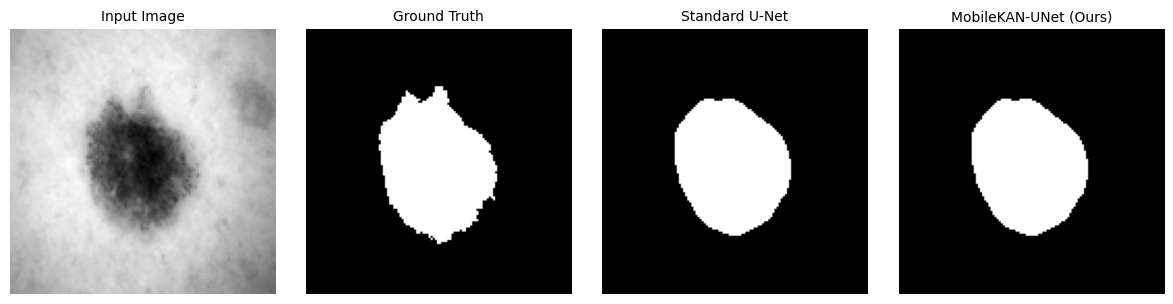

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define visualization function with the Fix
def visualize_comparison_fixed(model_kan, model_unet, loader, device, save_name="figure3_comparison.png"):
    model_kan.eval()
    model_unet.eval()

    # Get a batch
    try:
        images, masks = next(iter(loader))
    except StopIteration:
        loader_iter = iter(loader)
        images, masks = next(loader_iter)

    images = images.to(device)

    # Determine how many samples to plot (Max 3, or however many represent the batch)
    num_samples = min(3, images.shape[0])

    with torch.no_grad():
        # Predict MobileKAN
        pred_kan = model_kan(images)
        pred_kan = (torch.sigmoid(pred_kan) > 0.5).float()

        # Predict Standard U-Net
        pred_unet = model_unet(images)
        pred_unet = (torch.sigmoid(pred_unet) > 0.5).float()

    # --- THE FIX: squeeze=False ensures axes is always 2D [row, col] ---
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples), squeeze=False)

    titles = ["Input Image", "Ground Truth", "Standard U-Net", "MobileKAN-UNet (Ours)"]

    for i in range(num_samples):
        # 1. Input Image
        img_show = images[i].cpu().squeeze().numpy()
        axes[i, 0].imshow(img_show, cmap='gray')
        if i == 0: axes[i, 0].set_title(titles[0], fontsize=10)
        axes[i, 0].axis('off')

        # 2. Ground Truth
        mask_show = masks[i].cpu().squeeze().numpy()
        axes[i, 1].imshow(mask_show, cmap='gray')
        if i == 0: axes[i, 1].set_title(titles[1], fontsize=10)
        axes[i, 1].axis('off')

        # 3. Standard U-Net
        unet_show = pred_unet[i].cpu().squeeze().numpy()
        axes[i, 2].imshow(unet_show, cmap='gray')
        if i == 0: axes[i, 2].set_title(titles[2], fontsize=10)
        axes[i, 2].axis('off')

        # 4. MobileKAN (Ours)
        kan_show = pred_kan[i].cpu().squeeze().numpy()
        axes[i, 3].imshow(kan_show, cmap='gray')
        if i == 0: axes[i, 3].set_title(titles[3], fontsize=10)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    print(f"Success! Saved {save_name}")
    plt.show()

# Run the fixed function
visualize_comparison_fixed(mobile_kan, model, val_loader, device)

In [8]:
# Install lightweight profiling tool
!pip install thop

from thop import profile

def get_model_specs(model, input_size=(1, 1, 128, 128)):
    # Create dummy input
    input_tensor = torch.randn(input_size).to(next(model.parameters()).device)

    # Calculate FLOPs and Params
    flops, params = profile(model, inputs=(input_tensor, ), verbose=False)

    print(f"Model: {model.__class__.__name__}")
    print(f"Parameters: {params / 1e6:.2f} Million") # Convert to Millions
    print(f"GFLOPs: {flops / 1e9:.2f}") # Convert to Giga FLOPs
    print("-" * 20)

# Calculate for MobileKAN
get_model_specs(model)

# Calculate for Standard U-Net (if in memory)
# get_model_specs(unet_model)

Model: MobileKAN_UNet
Parameters: 0.03 Million
GFLOPs: 0.06
--------------------


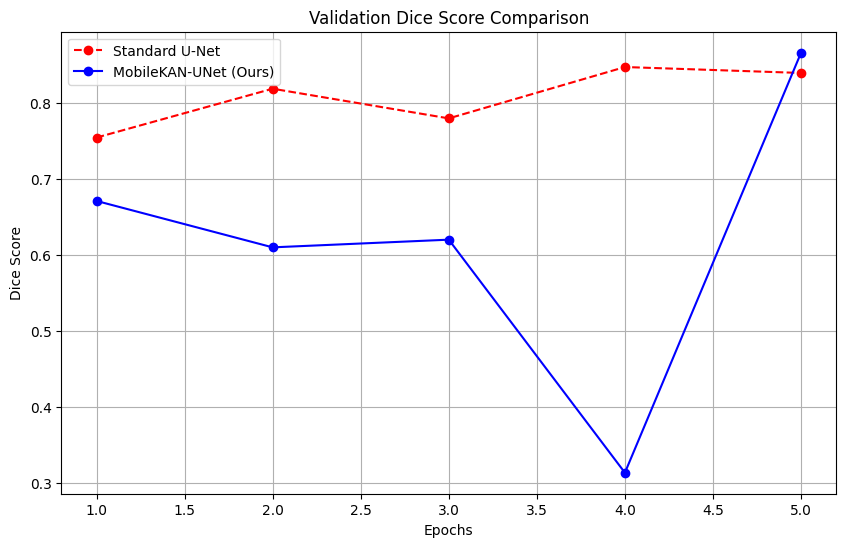

In [9]:
import matplotlib.pyplot as plt

# Data from your logs (Same as Priority 1)
epochs = [1, 2, 3, 4, 5]
mk_dice = [0.6707, 0.6097, 0.6198, 0.3135, 0.8655]
unet_dice = [0.7540, 0.8182, 0.7792, 0.8467, 0.8389]

plt.figure(figsize=(10, 6))
plt.plot(epochs, unet_dice, 'r--o', label='Standard U-Net')
plt.plot(epochs, mk_dice, 'b-o', label='MobileKAN-UNet (Ours)')

plt.title('Validation Dice Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.savefig('training_curve_comparison.png', dpi=300)
plt.show()